In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
stocksymlist = ["MSFT", "AXP", "BA", "CAT", "CVX", "CSCO", "KO", "DIS",  "XOM", "GE", "GS",
                "HD", "IBM", "JNJ", "JPM", "MCD", "MRK", "NKE", "PFE", "PG", "UTX", "UNH", "VZ",
                "V", "WMT"]


In [3]:
df_spy = pd.read_json('https://api.iextrading.com/1.0/stock/'
            +'spy'+'/chart/5y')
df_spy.head()

,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
0,1.14490,0.000000,0.775,148.8215,2013-06-17,149.5275,"Jun 17, 13",147.7167,148.6858,136114269,136114269,148.8463
1,1.17200,0.007876,0.788,149.9936,2013-06-18,150.2243,"Jun 18, 13",148.8940,148.9030,114592356,114592356,149.6537
2,-2.06800,-0.006020,-1.379,147.9256,2013-06-19,150.1338,"Jun 19, 13",147.8622,149.8714,205916944,205916944,149.2836
3,-3.66530,-0.030649,-2.478,144.2602,2013-06-20,147.9408,"Jun 20, 13",143.8801,146.4866,320785551,320785551,145.4225
4,0.46317,-0.027537,0.321,144.7234,2013-06-21,145.3512,"Jun 21, 13",143.2677,145.2420,271424782,271424782,144.4589


In [11]:
full_spy_close = np.array(df_spy['close'])[1:]

In [8]:
def fillDict():
    dfDict = {}
    for sym in stocksymlist:
        df_close = pd.DataFrame()
        df_temp = pd.read_json('https://api.iextrading.com/1.0/stock/'
            +sym+'/chart/5y')
        df_temp.set_index('date',inplace=True)
        #df_close = df_temp[['volume','close']]
        df_close = df_temp[['close']]

        dfDict[sym] = df_close
    return dfDict
dfDict = fillDict()
print("dict done")

dict done


In [9]:
len(full_spy_close)

1260

In [39]:
def calcCGRs(start):
    sigmas = []
    drifts = []
    closes = []
    cgrs = []
    covmat = []
    
    keys = dfDict.keys()
    
    for key in keys:
        stock = dfDict[key]
        price = np.array(stock.close)
        pricep1 = np.roll(price,1)
        lnratio = price/pricep1
        cgr = np.log(lnratio)
        cgr[0]=999.99
        cgr = cgr[start:start+252]
        spy_close = full_spy_close[start:start+252]
        spy_close = spy_close/spy_close[0]
        closes.append(price[start:start+252])
        sigma = np.std(cgr)
        sigmas.append(sigma)
        drift = np.mean(cgr)
        drifts.append(drift)
        cgrs.append(cgr)
        
    closes = np.array(closes)
    sigmas = np.array(sigmas)
    drifts = np.array(drifts)
    covmat = np.cov(cgrs)
    cgrs = np.array(cgrs)
    
    return (closes, sigmas, drifts, -drifts, spy_close, covmat, cgrs)

(closes, sigmas, drifts, ndrifts, spy, covmat, cgrs) = calcCGRs(len(dfDict["MSFT"])-252)

print("cgrs done")

cgrs done


In [13]:
def risk(weights):
    cv = np.dot(covmat, weights)
    return (np.dot(weights, cv))**0.5

In [14]:
def return_rate(weights):
        return np.dot(weights, drifts)

In [15]:
def return_rate2(weights):
        return -np.dot(weights, ndrifts)

In [16]:
 def sharpe(weights):
        return return_rate(weights)/risk(weights)

In [17]:
 def sharpe2(weights):
        return return_rate2(weights)/risk(weights)

In [18]:
def sharpe_grad(weights):
    sig = risk(weights)
    variance = sig**2
    cpi = np.dot(covmat, weights)
    grad = np.zeros(len(weights))
    for i in range(len(weights)):
        dpi = np.zeros(len(weights))
        dpi[i] = float(1)
        dsig = (np.dot(dpi,cpi)+np.dot(weights, np.dot(covmat, dpi))
            )/(2*sig)
        numer = weights[i]*drifts[i]*sig - np.dot(weights, drifts)*dsig
        grad[i] = numer/variance
    return grad

In [19]:
def sharpe_grad2(weights):
        sig = risk(weights)
        variance = sig**2
        cpi = np.dot(covmat, weights)
        grad = np.zeros(len(weights))
        for i in range(len(weights)):
            dpi = np.zeros(len(weights))
            dpi[i] = float(1)
            dsig = (np.dot(dpi,cpi)+np.dot(weights, np.dot(covmat, dpi))
                )/(2*sig)
            numer = weights[i]*ndrifts[i]*sig - np.dot(weights, ndrifts)*dsig
            grad[i] = numer/variance
        return grad

In [20]:
def ascent(epochs, learn_rate, short=True):
    weights = np.zeros(len(stocksymlist))+float(1)
    weights = weights/np.sum(weights)
    last_sharpe = -float("inf")
    for epoch in range(epochs):

         #get gradient for these weights
        grad = sharpe_grad(weights)
        grad *= 1.0/(np.dot(grad, grad)**0.5)

        #update weights
        weights += grad*learn_rate

        normal = np.zeros(len(stocksymlist))+float(1)
        normal *= (1-np.sum(weights))/len(stocksymlist)
        weights += normal

         #calculate new sharpe
        current_sharpe = sharpe(weights)

        #change learning rate
        if current_sharpe/last_sharpe < 1.0:
            learn_rate *= 0.8
        elif current_sharpe/last_sharpe > 1.001:
            learn_rate *= 1.1

        last_sharpe = current_sharpe

#             if epoch%100 == 0:
#                 print("sharpe", current_sharpe)
#                 print(np.sum(weights))

    return (weights, current_sharpe)



In [21]:
def ascent2(epochs, learn_rate, short=True):
        weights = np.zeros(len(stocksymlist))+float(1)
        weights = weights/np.sum(weights)
        last_sharpe = -float("inf")
        for epoch in range(epochs):
            
             #get gradient for these weights
            grad = sharpe_grad2(weights)
            grad *= 1.0/(np.dot(grad, grad)**0.5)

            #update weights
            weights -= grad*learn_rate
            
            normal = np.zeros(len(stocksymlist))+float(1)
            normal *= (1-np.sum(weights))/len(stocksymlist)
            weights += normal
            
             #calculate new sharpe
            current_sharpe = sharpe2(weights)

            #change learning rate
#             if current_sharpe/last_sharpe < 1:
#                 learn_rate *= 0.8
#             elif current_sharpe/last_sharpe > 1.02:
#                 learn_rate *= 1.05
            
            last_sharpe = current_sharpe
                
#             if epoch%100 == 0:
#                 print("sharpe", current_sharpe)
#                 print(np.sum(weights))

        return (weights, current_sharpe)



In [25]:
w, s = ascent(1000, .011)

In [26]:
print(return_rate(w))
print(risk(w))
w

0.000563288756317
0.00763232438478


array([ 0.03781605,  0.03882642,  0.03837343,  0.03698023,  0.04030219,
        0.03722185,  0.04395075,  0.04066061,  0.04136742,  0.03710635,
        0.03663985,  0.03930245,  0.03998807,  0.04065073,  0.0383129 ,
        0.04353967,  0.04040832,  0.04002419,  0.04087489,  0.0440575 ,
        0.04063718,  0.04064607,  0.04060194,  0.04032123,  0.04138971])

In [27]:
w, s = ascent2(1000, .011)

In [31]:
print(return_rate(w))
print(risk(w))
w

-0.0151933793874
0.111707443245


array([-1.07140316,  0.63640053, -4.24210564, -6.35697281,  0.75572164,
       -1.34047202,  0.4835943 ,  0.31938472,  0.30913984,  0.17316804,
       -0.05267016,  0.30562031,  0.39509747,  0.52575871,  0.37772217,
        1.05453288,  0.58879817,  1.06544182,  0.70826232,  0.29824867,
        0.26581688,  1.91447946,  0.58526828,  2.60296615,  0.69820143])

In [29]:
for i in range(len(stocksymlist)):
    pi = np.zeros(len(stocksymlist))
    pi[i] = float(1)
    print(sharpe(pi))
    
pi = np.zeros(len(stocksymlist))+float(1)
pi /= np.sum(pi)
print(sharpe(pi))


0.106677875401
0.0818780139371
0.160480094311
0.119103922407
0.0810882265542
0.0980350109636
-0.00132199946308
-0.0183871012499
0.00879383078088
-0.146773295063
0.0254196098088
0.0725291368017
-0.000888319053949
0.0214873890568
0.0950782184523
0.0575297866356
-0.00999745118237
0.0642201176346
0.0423703903009
-0.0597008481714
0.0160690542498
0.106175543603
0.0327657001875
0.12685454665
0.0323962673676
0.0745145870516


In [244]:
len(closes[0])

252

In [81]:
def backtest(days):
    benchw = np.zeros(len(stocksymlist)) + float(1)
    benchw /= np.sum(benchw)
    dailyvalues = [[10000.0], [10000.0], [10000.0]]
    capital = float(10000.0)
    capital2 = float(10000.0)
    benchcap = float(10000.0)# = [float(10000.0)/len(benchw) for i in benchw]
    startdate = len(dfDict["MSFT"])-252-days-1
    for day in range(days):
        date = startdate+day
        #get new values
        (closes, sigmas, drifts, ndrifts, spy, covmat, cgrs) = calcCGRs(date)

        weights = 2*ascent(2000, 0.001)[0]
        sweights = ascent2(2000, 0.001)[0]
        
        #weights = ascent(1000, 0.001)[0]


        dailyret = float(0)
        sdailyret = float(0)
        for i in range(len(weights)):
            dailyret += weights[i]*closes[i][day+1]/closes[i][day]
            sdailyret -= sweights[i]*closes[i][day+1]/closes[i][day]
        
        capital *= (((dailyret-1)*2) + (sdailyret-1)) +1
        capital2 *= dailyret
        
        dailyvalues[0].append(capital)
        dailyvalues[1].append(capital2)
        dailyvalues[2].append(10000.0*spy[day])
        
        if day%10==0:
            print("capital: ", capital)#, "benchmark: ", benchcap)
    print("final capital = ", capital)
    return np.array(dailyvalues)

In [78]:
def backtest2(days):
    benchw = np.zeros(len(stocksymlist)) + float(1)
    benchw /= np.sum(benchw)
    dailyvalues = [[10000.0], [10000.0]]
    capital = float(10000.0)
    benchcap = float(10000.0)# = [float(10000.0)/len(benchw) for i in benchw]
    startdate = len(dfDict["MSFT"])-252-days-1
    for day in range(days):
        date = startdate+day
        #get new values
        (closes, sigmas, drifts, ndrifts, spy, covmat, cgrs) = calcCGRs(date)

        #weights = 2*ascent(2000, 0.001)[0]-ascent2(2000, 0.001)[0]
        weights = ascent(1000, 0.001)[0]


        dailyret = float(0)
        for i in range(len(weights)):
            dailyret += weights[i]*closes[i][day+1]/closes[i][day]
        capital *= dailyret
        
        dailyvalues[0].append(capital)
        dailyvalues[1].append(10000.0*spy[day])
        
        if day%10==0:
            print("capital: ", capital)#, "benchmark: ", benchcap)
    print("final capital = ", capital)
    return np.array(dailyvalues)

In [82]:
d = 250
dvals = backtest(d)

capital:  10292.7978776
capital:  11014.8364305
capital:  10847.8514607
capital:  10381.7116221
capital:  9954.27405691
capital:  10323.6427591
capital:  10633.0217118
capital:  12459.7927777
capital:  12794.3795152
capital:  12869.2801562
capital:  13845.9366888
capital:  13988.9147701
capital:  14092.2631583
capital:  13889.3322872
capital:  13819.1841386
capital:  15111.7171598
capital:  15719.7308418
capital:  16649.7729559
capital:  17612.9936849
capital:  17902.544472
capital:  20003.0167197
capital:  21310.1696955
capital:  19375.7185112
capital:  19361.2961941
capital:  19017.5515448
final capital =  18436.9183799


In [79]:
dvals2 = backtest2(d)

capital:  10092.3087875
capital:  10279.5672093
capital:  10290.8929644
capital:  10118.4682323
capital:  10010.816776
capital:  10110.3447152
capital:  10192.8952473
capital:  10668.235992
capital:  10774.6096465
capital:  10783.2148174
capital:  11052.8677247
capital:  11071.5732219
capital:  11112.8412246
capital:  11123.3305566
capital:  11097.2917945
capital:  11363.3401392
capital:  11517.5326136
capital:  11655.4723703
capital:  11843.030734
capital:  11898.4015519
capital:  12313.3604103
capital:  12506.0265004
capital:  12136.4922083
capital:  12105.4784126
capital:  12087.4919408
final capital =  12050.1150027


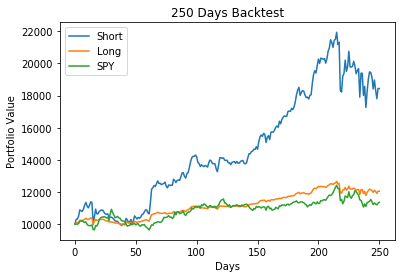

In [85]:
days = range(0,d+1)
algo, = plt.plot(days, dvals[0], label="Short")
long, = plt.plot(days, dvals2[0], label="Long")
bench, = plt.plot(days, dvals2[1], label="SPY")
plt.ylabel("Portfolio Value")
plt.xlabel("Days")
plt.title(str(d)+" Days Backtest")
plt.legend()
plt.show()

In [66]:
dvals[1]

array([  1.00000000e+04,   2.01846176e+04,   4.03457024e+04,
         8.09843008e+04,   1.63930547e+05,   3.27598100e+05,
         6.53198143e+05,   1.31096995e+06,   2.63965966e+06,
         5.30520217e+06,   1.05535286e+07,   2.10525536e+07,
         4.23185724e+07,   8.51512332e+07,   1.69826408e+08,
         3.28141759e+08,   6.66678958e+08,   1.34944958e+09,
         2.68420309e+09,   5.36354814e+09,   1.07703818e+10,
         2.15815668e+10,   4.31854525e+10,   8.64527167e+10,
         1.72292206e+11,   3.43128002e+11,   6.84132778e+11,
         1.36758983e+12,   2.72167324e+12,   5.44479919e+12,
         1.08796082e+13,   2.17292451e+13,   4.33990211e+13,
         8.64354919e+13,   1.73101241e+14,   3.45940123e+14,
         6.89855991e+14,   1.37642397e+15,   2.74636044e+15,
         5.49913329e+15,   1.10263781e+16,   2.20140189e+16,
         4.46399202e+16,   8.89768778e+16,   1.77056602e+17,
         3.54478360e+17,   7.12872075e+17,   1.41163467e+18,
         2.83719357e+18,

In [ ]:
dvals[0]